In [3]:
import networkx as nx
import numpy as np
import scipy as math
import json
import os.path as path
import matplotlib.pyplot as plt 
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 14, 10
root_dir = '../' 

if nx.__version__ == '1.11':
  nx.read_dot = nx.drawing.nx_agraph.read_dot
  nx.graphviz_layout = nx.drawing.nx_agraph.graphviz_layout
  nx.drawing.graphviz_layout = nx.graphviz_layout
  nx.draw_graphviz = nx.drawing.nx_pylab.draw_graphviz

## 0.Utils

#### Загрузка всех топологий кроме тора(тк для тора храняться только вероятност ребер, а не сама струтура): 

In [4]:
def load_graph_from_dot(filename):
    """
    Reads networkx graph from a dot file
    :param filename: name of the dot file with graph info
    :return: networkx graph
    """
    graph = nx.read_dot(filename)
    for e in graph.edges_iter(data=True):
        e[2]['is_available'] = e[2]['is_available'] == 'True'
        e[2]['prob'] = float(e[2]['prob'].strip('"'))
    
    if type(graph) is nx.MultiGraph:    
        really_multi_graph = any(len(graph[v][u]) > 1 for v, u in graph.edges())
        assert (not really_multi_graph), 'This graph contains parallel edges!'
        graph = nx.Graph(graph)
    #for some reason nx.read_dot creates nodes with string id instead of integer one:
    graph = nx.relabel_nodes(graph, {n:int(n) for n in graph})
    return graph


BA_envs = {
    'small': path.join(root_dir, 'env_data/barabasi_albert/N25_M3/{env_id}.dot'),
    'medium': path.join(root_dir, 'env_data/barabasi_albert/N100_M3/{env_id}.dot'),
    'big': path.join(root_dir, 'env_data/barabasi_albert/N400_M3/{env_id}.dot'),
}

ER_envs = {
    'small': path.join(root_dir, 'env_data/erdos_renyi/n25_p0.25/{env_id}.dot'),
    'medium': path.join(root_dir, 'env_data/erdos_renyi/n100_p0.06/{env_id}.dot'),
    'big': path.join(root_dir, 'env_data/erdos_renyi/n400_p0.015/{env_id}.dot'),
}

WA_envs = {
    'small' : path.join(root_dir, 'env_data/watts_strogatz/N25_K6_b0.1/{env_id}.dot'),
    'medium' : path.join(root_dir, 'env_data/watts_strogatz/N100_K6_b0.1/{env_id}.dot'),
    'big': path.join(root_dir, 'env_data/watts_strogatz/N400_K6_b0.1/{env_id}.dot'),
}


def load_barabasi_albert(env_id, env_size='small'):
    return load_graph_from_dot(BA_envs[env_size].format(env_id=env_id))

def load_watts_strogatz(env_id, env_size='small'):
    return load_graph_from_dot(WA_envs[env_size].format(env_id=env_id))
                               
def load_erdos_renyi(env_id, env_size='small'):
    return load_graph_from_dot(ER_envs[env_size].format(env_id=env_id))


#### Функции для загрузки тора:

In [6]:
def get_json_data(filename):
    """Reads data from json file"""
    data = None
    with open(filename, "r") as the_file:
        data = json.load(the_file)

    return data

def create_torus(x, y, get_probabilities=None):
    size = int(np.ceil(np.log2(x*y)))
    binary =  '{0:0' + str(size) + 'b}'
    torus = nx.Graph()
    grid = np.empty((x,y), dtype=int)
    
    for i in xrange(x):
        for j in xrange(y):
            index = i*y + j 
            torus.add_node(index, binary_code=binary.format(index))
            grid[i][j] = index
        
    n_edges = x*y*2
    probs = get_probabilities(n_edges)
    edges = []
    for i in xrange(x): 
        for j in xrange(y):
            edge_id = (i*y + j)*2
            edges.append((grid[i][j], grid[i][(j+1) % y],probs[edge_id]))
            edges.append((grid[i][j], grid[(i+1) % x][j], probs[edge_id+1]))
            
    torus.add_weighted_edges_from(edges,weight='prob')
    return torus
  
def load_torus(x,y, env_id):
    file_template = path.join(root_dir, "env_data/torus_probs/{0}x{1}/{2}.json")
    probs = get_json_data(file_template.format(x,y,env_id))
    get_probs = lambda n: probs[:n]
    return create_torus(x, y, get_probs)

def load_arbitray_torus(x, y, env_id):
    if x*y > 20*20 or x<1 or y < 1:
        raise ValueError("Can't load torus of that size!")
    file_template = path.join(root_dir, "env_data/torus_probs/20x20/{0}.json")    
    probs = get_json_data(file_template.format(env_id))
    get_probs = lambda n: probs[:n]
    return create_torus(x, y, get_probs)



#### другие вспомогательные функции: 

In [7]:
def get_start_and_target(env_graph):
    return 0, env_graph.number_of_nodes() / 2

#torus target is different if x is even:
def get_torus_start_and_target(x,y):
    return 0, (x/2) * y + y / 2

def divide_perm_and_stoch_edges(edges, graph):
    perm_e = []
    perm_w = []
    twin_perm_e = []
    twin_perm_w = []
    
    stoch_e = []
    stoch_w = []
    twin_stoch_e = []
    twin_stoch_w = []
    for e in edges:
        v,u = e
        w = graph[u][v]['prob']
        if w < 1.:
            stoch_e.append(e)
            stoch_w.append(w)
        else:
            perm_e.append(e)
            perm_w.append(w)
            
    return perm_e, perm_w, stoch_e, stoch_w


## 1. Vizualization

In [8]:
default_node_style = {
    'node_color':'w',
    'node_size': 800.
}
target_style = {
    'node_color':'red',
    'node_size': 1000.
}

stochastic_style = {
    'alpha':0.9,
    'edge_color':'gray'
}

permanent_style = {
    'alpha':0.9,
    'edge_color':'blue'
}


def draw_random_env(graph, pos, 
                    special_nodes=tuple(), weight_multiplier=5.,
                    node_style=None, special_style=None,
                    stoch_style=None, perm_style=None,
                    label_style=None):

    if not node_style: node_style = default_node_style
    if not special_style: special_style = target_style
    
    if not stoch_style: stoch_style = stochastic_style    
    if not perm_style: perm_style = permanent_style    
    if not label_style: label_style = {}

    nodes = [n for n in graph.nodes() if n not in special_nodes]
    perm_e, perm_w, stoch_e, stoch_w = divide_perm_and_stoch_edges(graph.edges(), graph)
    
    stoch_w = np.array(stoch_w) * weight_multiplier
    perm_w = np.array(perm_w) * weight_multiplier
    
    
    nx.draw(graph, pos, nodelist=[], edgelist=[])
    nx.draw_networkx_nodes(graph, pos, nodelist=nodes, **node_style)
    nx.draw_networkx_nodes(graph, pos, nodelist=special_nodes, **special_style)
    nx.draw_networkx_labels(graph, pos, **label_style)
    #draw stochastic edges
    nx.draw_networkx_edges(graph, pos, edgelist=stoch_e, width=stoch_w, **stoch_style)  
    #draw permanent edges above stochastic
    nx.draw_networkx_edges(graph, pos, edgelist=perm_e, width=perm_w, **perm_style)

### Watts-Strogatz environment

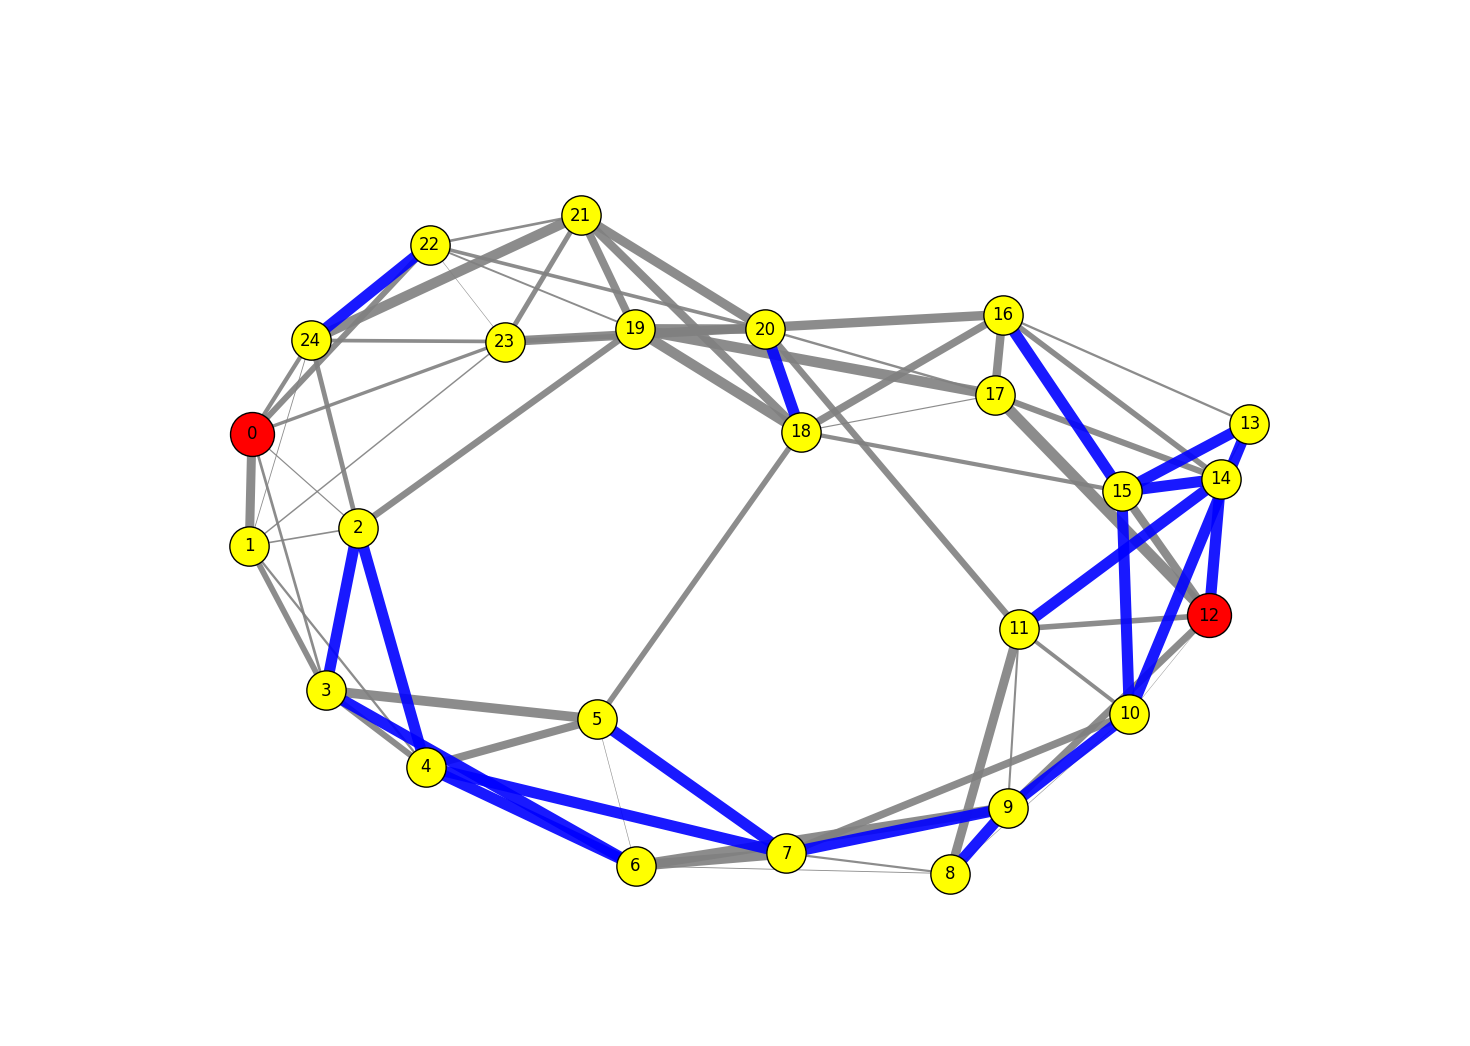

In [9]:
# 'circular_layout',
# 'random_layout',
# 'shell_layout',
# 'spring_layout',
# 'spectral_layout',
# 'fruchterman_reingold_layout'
graph = load_watts_strogatz(1)
special_nodes = get_start_and_target(graph)
pos = nx.fruchterman_reingold_layout(graph)
draw_random_env(graph, pos, special_nodes, weight_multiplier=8.,
                node_style={'node_color':'yellow', 'node_size':800.})

### Erdos-Renyi environment

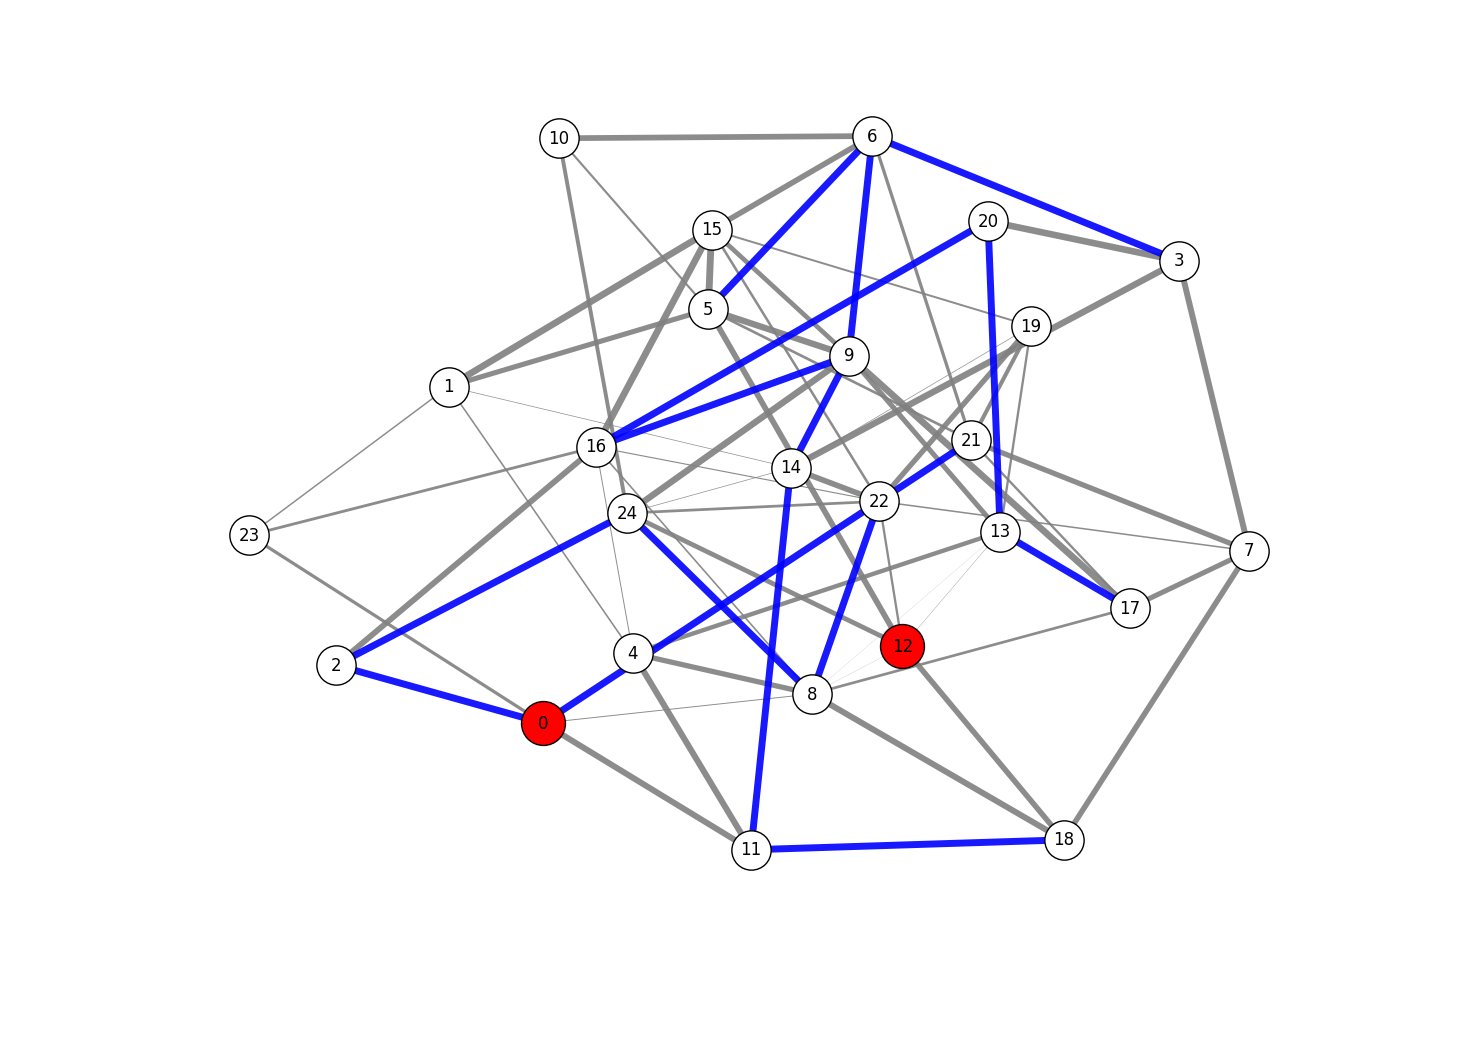

In [10]:
# 'circular_layout',
# 'random_layout',
# 'shell_layout',
# 'spring_layout',
# 'spectral_layout',
# 'fruchterman_reingold_layout'
graph = load_erdos_renyi(9)
special_nodes = get_start_and_target(graph)
pos = nx.fruchterman_reingold_layout(graph)
#pos = nx.spring_layout(graph)
draw_random_env(graph, pos, special_nodes)

### Barabasi-Albert environment

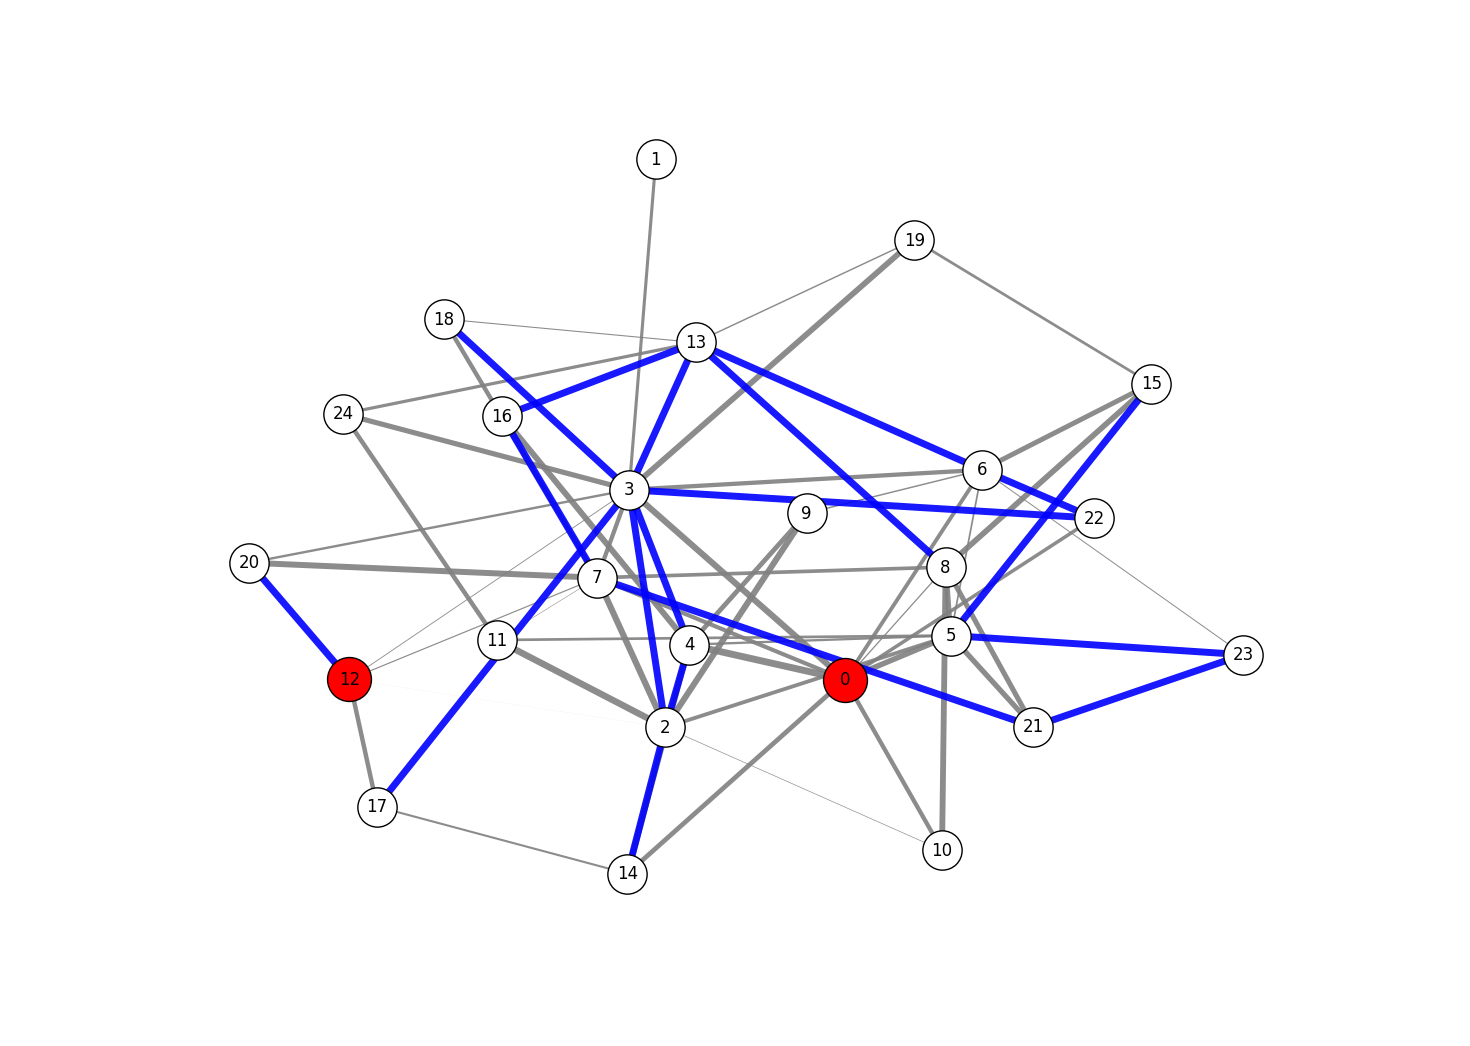

In [11]:
# 'circular_layout',
# 'random_layout',
# 'shell_layout',
# 'spring_layout',
# 'spectral_layout',
# 'fruchterman_reingold_layout'
graph = load_barabasi_albert(1)
special_nodes = get_start_and_target(graph)
pos = nx.spring_layout(graph)
draw_random_env(graph, pos, special_nodes)

### Torus environment

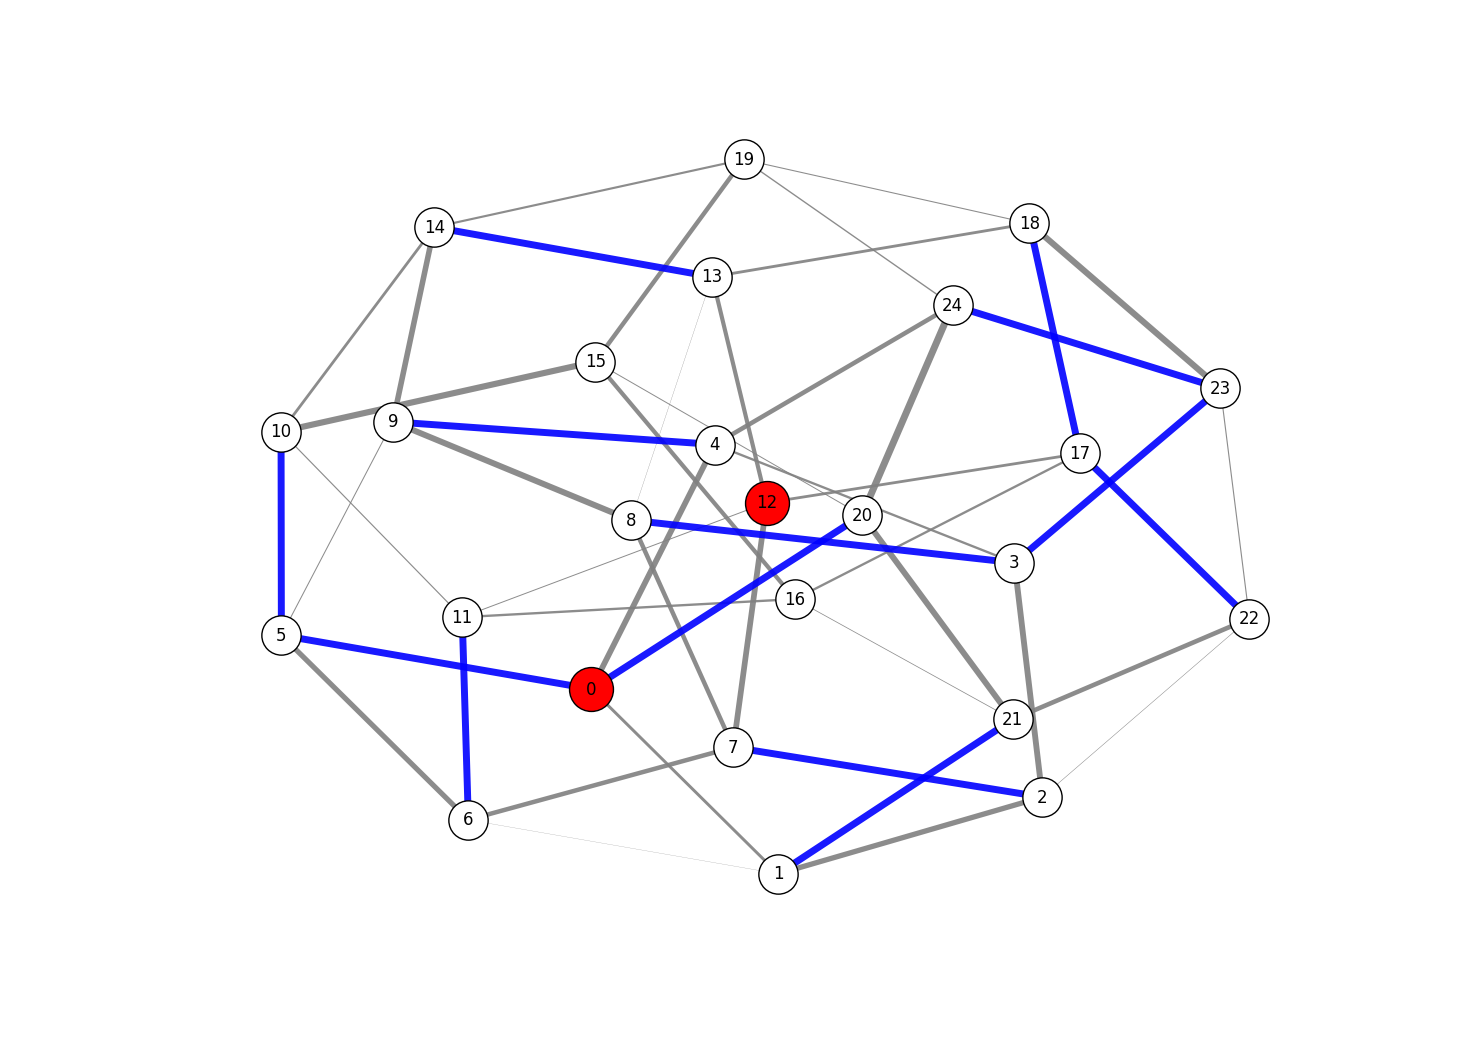

In [12]:
graph = load_torus(5, 5, 2)
special_nodes = get_torus_start_and_target(5,5)
pos = nx.graphviz_layout(graph)#nx.spring_layout(graph)
draw_random_env(graph, pos, special_nodes)

## 2. Vizualization only for torus topology

#### Первый способ: просто убираем циклические ребра и размещаем вершины на решетке.

In [13]:

def grid_layout(x, y, row_dist=30., column_dist=30.):
    return {i*y+j:(j*column_dist, i*row_dist) for i in xrange(x) for j in xrange(y)}
       

def filter_out_grid_circle_edges(torus_graph, x, y):
    grid_inner_edges = []
    for e in torus_graph.edges():
        v,u = e
        id_dist = abs(v - u)
        if id_dist == 1 or id_dist == y:
            grid_inner_edges.append(e)
            
    return grid_inner_edges

def grid_witout_circle_edges(torus_graph, x,y):
    grid = torus_graph.copy()
    edges = grid.edges()
    
    for e in edges:
        v,u = e
        id_dist = abs(v - u)
        is_inner_edge = (id_dist == 1 or id_dist == y)
        
        if not is_inner_edge:
            grid.remove_edge(*e)
    
    return grid     


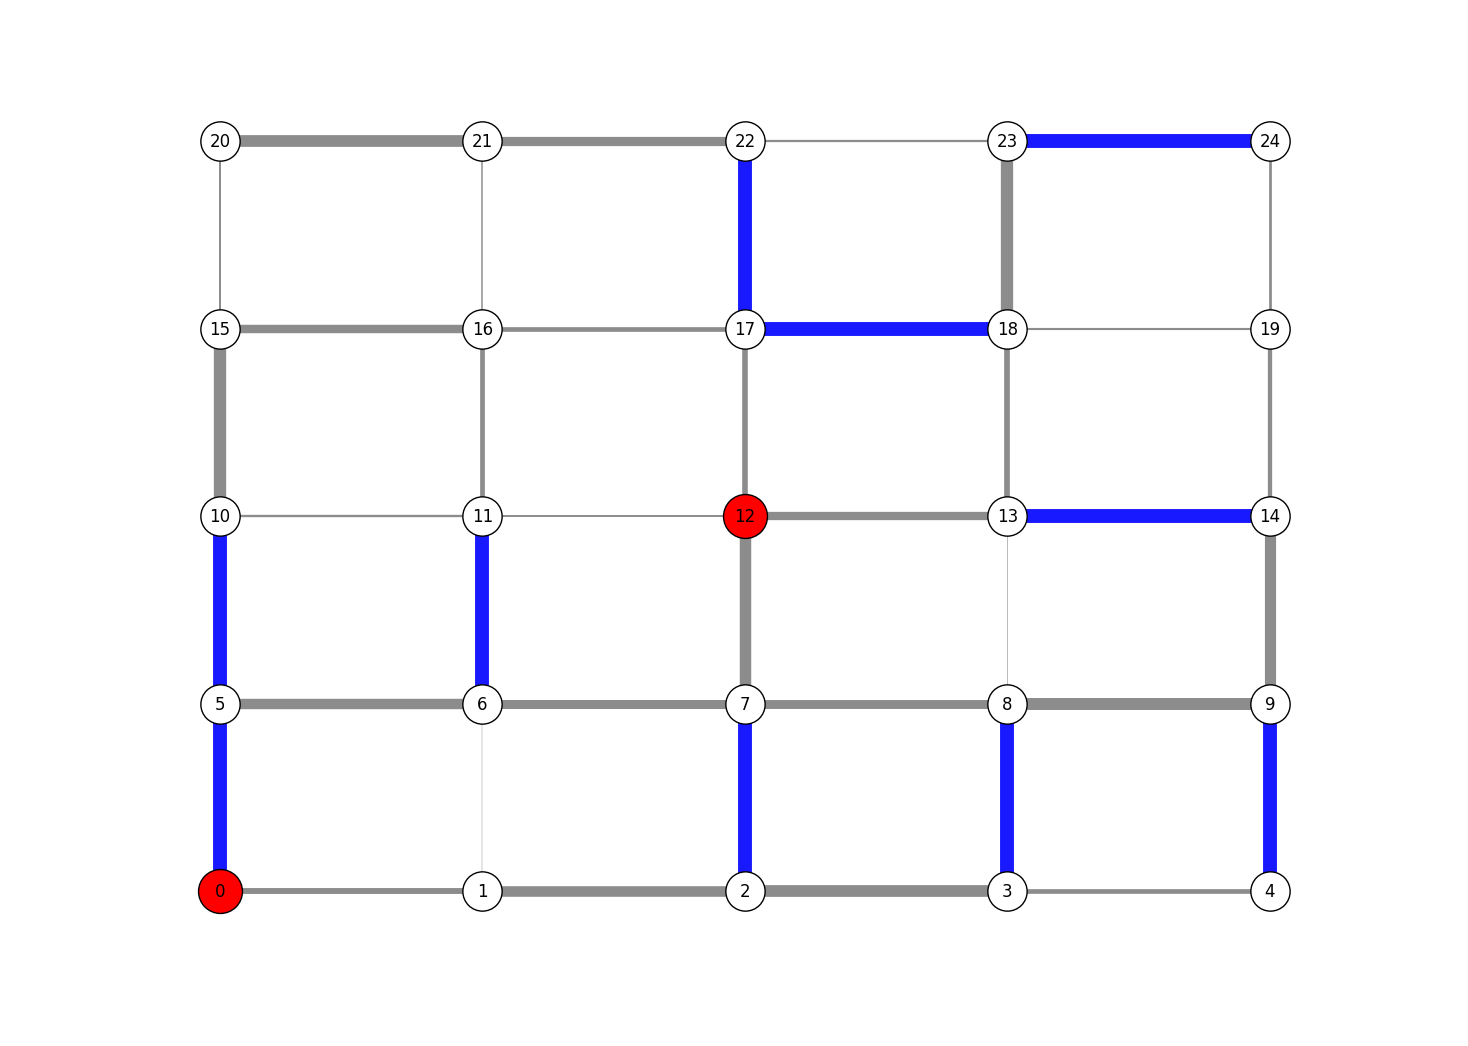

In [14]:
x,y, env_id = 5, 5, 2

torus = load_torus(x, y, env_id)
special_nodes = get_torus_start_and_target(5,5)

grid = grid_witout_circle_edges(torus, x, y)
pos = grid_layout(x, y)

draw_random_env(grid, pos, special_nodes, weight_multiplier=10.)

#### Второй способ: Создаем копии вершин из верхней строки и последнего столбца и протягиваем ребра к ним 

In [15]:
def create_grid_with_twin_nodes(torus, x,y):
    grid = torus.copy()
    inner_edges = set(filter_out_grid_circle_edges(grid, x, y))
    twin_row = []
    twin_column = []
    
    for e in grid.edges(): 
        if e not in inner_edges:
            v,u = e
            e_data = grid[v][u]
            
            grid.remove_edge(*e)
            
            v, u = min(e), max(e)
            twin_u = None
            
            if u - v == (x-1)*y: #  edge: first row node <==> last row node
                twin_u = (u,'twin_row')
                twin_row.append(twin_u)
            elif u - v == y - 1: #edge: first column node <==> last column node
                twin_u = (u,'twin_column')
                twin_column.append(twin_u) 
            
            
            grid.add_node(twin_u)
            grid.add_edge(v, twin_u, **e_data)
            
            
    return grid, sorted(twin_row), sorted(twin_column)

def grid_layout_with_twin_nodes(x,y, twin_row, twin_column, row_dist=30., column_dist=30.):
    '''
    twin_row, twin_column are lists of nodes were each nodes is a tuple:(original_node_id, ..)
    '''
    pos = {i*y+j:(j*column_dist, i*row_dist) for i in xrange(x) for j in xrange(y)}
    
    for node in twin_row:
        x, y = pos[node[0]]  
        pos[node] = (x, - row_dist)
    
    for node in twin_column:
        x, y = pos[node[0]]  
        pos[node] = ( - column_dist, y)
    
    return pos


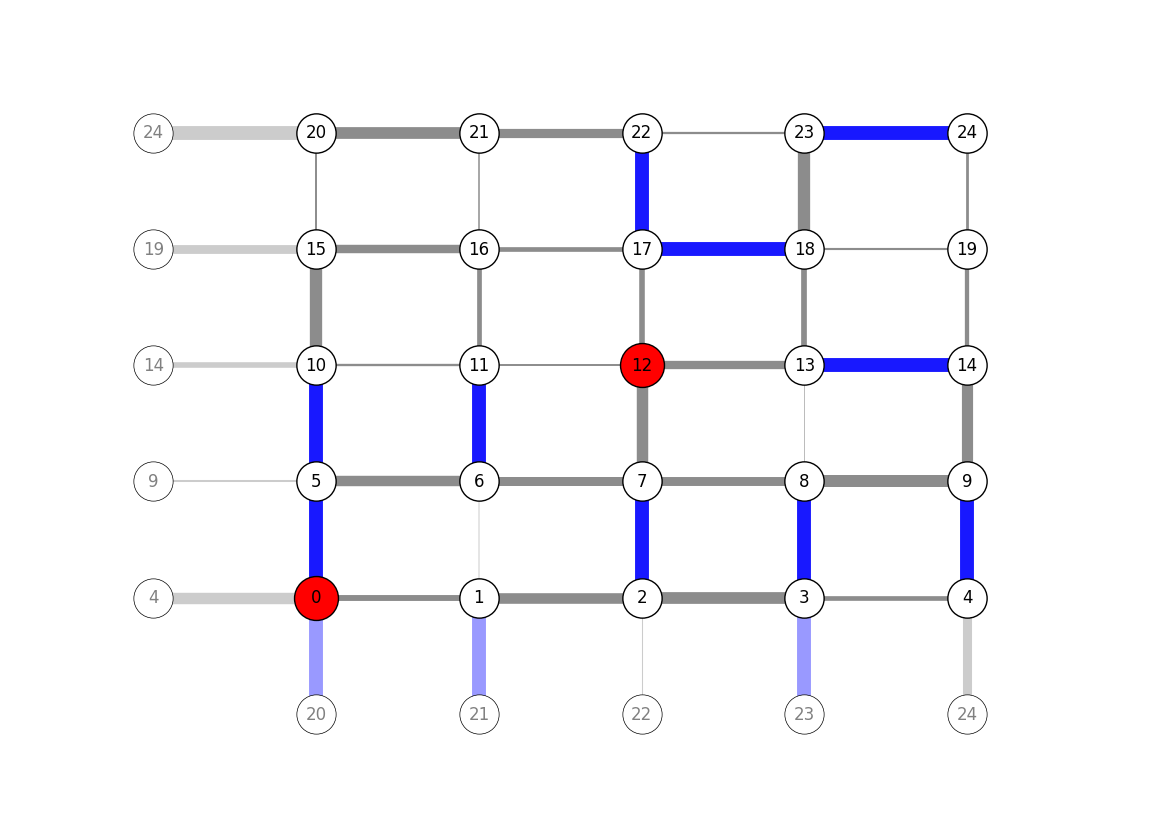

In [16]:
twin_node_style = {
    'alpha':1.,
    'node_color':'w',
    'node_size':800.,
    'linewidths':.5
}
twin_label_style = {
    'font_color':'gray'
}     

twin_stoch_style = {
    'edge_color':'gray',
    'alpha': 0.4

}

twin_perm_style = {
    'edge_color':'blue',
    'alpha': 0.4
}


x, y, env_id = 5,5,2 
weight_multiplier=10.,


torus = load_torus(x, y, env_id)
special_nodes = get_torus_start_and_target(x, y)
original_nodes = [n for n in torus.nodes() if n not in special_nodes]


grid, twin_row, twin_column = create_grid_with_twin_nodes(torus, x,y)
pos = grid_layout_with_twin_nodes(x,y, twin_row, twin_column)

#draw nodes and lables

nx.draw_networkx_nodes(grid, pos, nodelist=original_nodes, **default_node_style)
nx.draw_networkx_nodes(grid, pos, nodelist=special_nodes, **target_style)
nx.draw_networkx_nodes(grid, pos, nodelist=twin_row + twin_column, 
                       **twin_node_style)

nx.draw_networkx_labels(grid, pos, labels={n:n for n in torus.nodes()})
nx.draw_networkx_labels(grid, pos, labels={n:n[0] for n in twin_row + twin_column},
                        **twin_label_style)

#draw ordinary edges
old_edges = set(torus.edges()) 

edges = [e for e in grid.edges() if e in old_edges]
perm_e, perm_w, stoch_e, stoch_w = divide_perm_and_stoch_edges(edges, grid)
stoch_w = np.array(stoch_w) * weight_multiplier
perm_w = np.array(perm_w) * weight_multiplier

nx.draw_networkx_edges(grid, pos, edgelist=stoch_e, width=stoch_w, **stochastic_style)  
nx.draw_networkx_edges(grid, pos, edgelist=perm_e, width=perm_w, **permanent_style)

#draw edges to twin nodes
twin_edges = [e for e in grid.edges() if e not in old_edges]
perm_e, perm_w, stoch_e, stoch_w = divide_perm_and_stoch_edges(twin_edges, grid)
stoch_w = np.array(stoch_w) * weight_multiplier
perm_w = np.array(perm_w) * weight_multiplier

nx.draw_networkx_edges(grid, pos, edgelist=stoch_e, width=stoch_w, **twin_stoch_style)  
nx.draw_networkx_edges(grid, pos, edgelist=perm_e, width=perm_w, **twin_perm_style)

plt.axis('off')
pass

## Черновики

tansitions:66
max_fs: 24


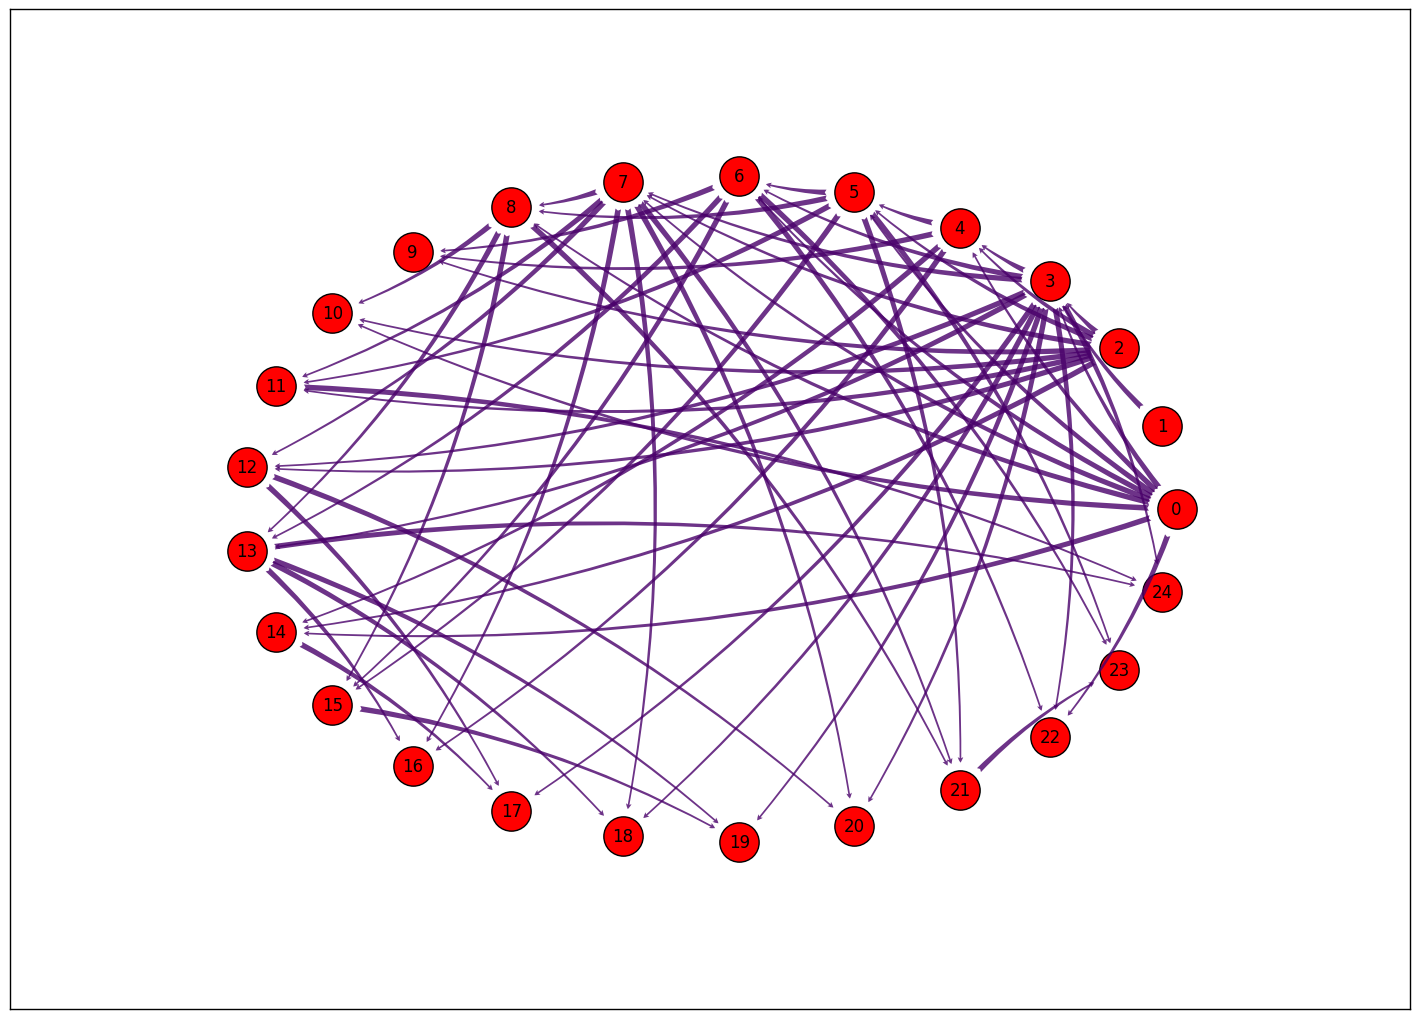

In [17]:
def drawStateTransitions(G):
    """draws transitions"""

    #max_fs = max(net.keys())
    #G = nx.MultiDiGraph()
    #states = []
    #for fs in net.values():
    #    st = vec2st(dict(fs.problemValues.items()[:dim]))
    #    if st not in states:
    #        states.append(st)
    #    start = vec2st(dict(fs.problemValues.items()[:dim]))
    #    end = vec2st(dict(fs.goalValues.items()[:dim]))
    #    G.add_edge(start, end, key=0, weight=fs.ID, label=str(fs.ID))

    # G.add_nodes_from(states)
    G = nx.MultiGraph(load_barabasi_albert(1)) #nx.MultiGraph(load_torus(x, y, 2))
    #for v,u in G.edges():
    #    G[v][u]['key'] = 0
    #    print G[v][u]
    edge_attr = 'prob' #'weight'
    max_fs = G.number_of_nodes() - 1
    node_layout = nx.circular_layout(G)
    plt.cla()
    nx.draw_networkx_nodes(G, pos=node_layout, node_size=800)
    nx.draw_networkx_labels(G, pos=node_layout)
    ar = plt.axes()
    actArrStyle = dict(arrowstyle='fancy',
                       shrinkA=20, shrinkB=20, aa=True,
                       fc="red", ec="none", alpha=0.1,
                       connectionstyle="arc3,rad=-0.1", )
    inhibitionArrStyle = dict(arrowstyle='fancy',
                              shrinkA=20, shrinkB=20, aa=True,
                              fc="blue", ec="none", alpha=0.6,
                              connectionstyle="arc3,rad=-0.13", )
    predArrStyle = dict(arrowstyle='fancy',
                        shrinkA=20, shrinkB=20, aa=True,
                        fc="green", ec="none", alpha=0.7,
                        connectionstyle="arc3,rad=0.2", )
    print "tansitions:"+str(len(G.edges()))
    print "max_fs:", max_fs
    for vertex in G.edges(keys=True,data=True):  # drawing links
        if vertex[3][edge_attr] != 0:
            coords = [node_layout[vertex[1]][0],
                      node_layout[vertex[1]][1],
                      node_layout[vertex[0]][0],
                      node_layout[vertex[0]][1]]
            if vertex[2] == 3:#0:
                if vertex[3][edge_attr] > 0:
                    actArrStyle['connectionstyle'] = 'arc3,rad='\
                                                     + str(0.4*math.log(vertex[3][edge_attr])/math.log(max_fs)+math.rand()*0.01)
                    print "fs:", vertex[3][edge_attr], ' ann:', actArrStyle['connectionstyle']
                    ar.annotate('',
                                (coords[0], coords[1]), (coords[2], coords[3]),
                                arrowprops=actArrStyle)
            if vertex[2] == 1:
                predArrStyle['fc'] = plt.cm.Greens(vertex[3][edge_attr]*255)
                ar.annotate('', (coords[0], coords[1]), (coords[2], coords[3]),
                            arrowprops=predArrStyle)
            if vertex[2] == 2:
                inhibitionArrStyle['fc'] = plt.cm.Blues(vertex[3][edge_attr]*255)
                ar.annotate('', (coords[0], coords[1]), (coords[2], coords[3]),
                            arrowprops=inhibitionArrStyle)
            if vertex[2] == 0:
                actArrStyle['fc'] = plt.cm.RdPu(vertex[3][edge_attr]*255)
                actArrStyle['alpha'] = 0.8
                ar.annotate('', (coords[0], coords[1]), (coords[2], coords[3]),
                            arrowprops=actArrStyle)

    ar.xaxis.set_visible(False)
    ar.yaxis.set_visible(False)
    plt.subplots_adjust(left=0.0, right=1., top=1., bottom=0.0)

    
drawStateTransitions(torus)    

In [18]:
G = nx.MultiGraph()  # or MultiDiGraph
G.add_path([0,1,2])
G.add_edge(2,3,weight=5)
print G.edges()
print G.edges(data=True)
print G.edges(keys=True)
print G.edges(keys=True, data=True)

[(0, 1), (1, 2), (2, 3)]
[(0, 1, {}), (1, 2, {}), (2, 3, {'weight': 5})]
[(0, 1, 0), (1, 2, 0), (2, 3, 0)]
[(0, 1, 0, {}), (1, 2, 0, {}), (2, 3, 0, {'weight': 5})]


In [19]:
def test():
    load_funcs = [load_erdos_renyi]#, load_watts_strogatz, load_barabasi_albert]
    for load_func in load_funcs:
        for i in xrange(1,2):
            G = load_func(1)
            e = np.array(G.edges())
            e_weights = np.array([G[u][v]['prob'] for u,v in e])
            is_permanent = (e_weights == 1.)
            is_stochastic =(e_weights < 1.)
            assert len(e_weights[is_permanent]) + len(e_weights[is_stochastic]) == len(e_weights),'Неравное число вершин'
            assert np.all(e_weights[is_permanent] == 1.0), 'В перманентные записали стохастическое ребро!'
            assert np.all(e_weights[is_stochastic] < 1.0), 'В стохастические записали перманентое ребро!'
            e_stoch = e[is_stochastic]
            for j in xrange(len(e_stoch)):
                v,u = e_stoch[j]
                assert G[v][u]['prob'] == e_weights[is_stochastic][j], 'Неверно cопоставили ребра!!!!'
            print load_func.__name__, i, ': all correct!'
test()    

load_erdos_renyi 1 : all correct!


In [20]:
def test2():
    G = load_erdos_renyi(1)
    edges = G.edges()
    for e in edges:
        v,u = e
        print e, v,u
        
test2()        

(0, 1) 0 1
(0, 2) 0 2
(0, 11) 0 11
(0, 4) 0 4
(0, 13) 0 13
(1, 17) 1 17
(1, 3) 1 3
(1, 7) 1 7
(2, 24) 2 24
(2, 16) 2 16
(3, 4) 3 4
(3, 14) 3 14
(3, 16) 3 16
(3, 22) 3 22
(3, 24) 3 24
(4, 5) 4 5
(4, 6) 4 6
(4, 8) 4 8
(4, 15) 4 15
(4, 16) 4 16
(4, 20) 4 20
(5, 16) 5 16
(5, 19) 5 19
(5, 20) 5 20
(6, 9) 6 9
(6, 11) 6 11
(6, 12) 6 12
(6, 14) 6 14
(6, 24) 6 24
(7, 10) 7 10
(7, 16) 7 16
(7, 20) 7 20
(7, 22) 7 22
(7, 23) 7 23
(8, 10) 8 10
(8, 15) 8 15
(8, 17) 8 17
(8, 21) 8 21
(8, 24) 8 24
(9, 16) 9 16
(9, 12) 9 12
(10, 15) 10 15
(10, 19) 10 19
(10, 21) 10 21
(11, 14) 11 14
(11, 16) 11 16
(11, 20) 11 20
(11, 22) 11 22
(12, 14) 12 14
(12, 15) 12 15
(12, 18) 12 18
(12, 21) 12 21
(12, 23) 12 23
(13, 24) 13 24
(13, 14) 13 14
(14, 15) 14 15
(14, 19) 14 19
(14, 23) 14 23
(15, 16) 15 16
(15, 22) 15 22
(15, 24) 15 24
(16, 17) 16 17
(17, 19) 17 19
(17, 22) 17 22
(18, 20) 18 20
(18, 22) 18 22
(19, 20) 19 20
(19, 21) 19 21
(19, 23) 19 23
(19, 24) 19 24
(21, 22) 21 22
(22, 23) 22 23


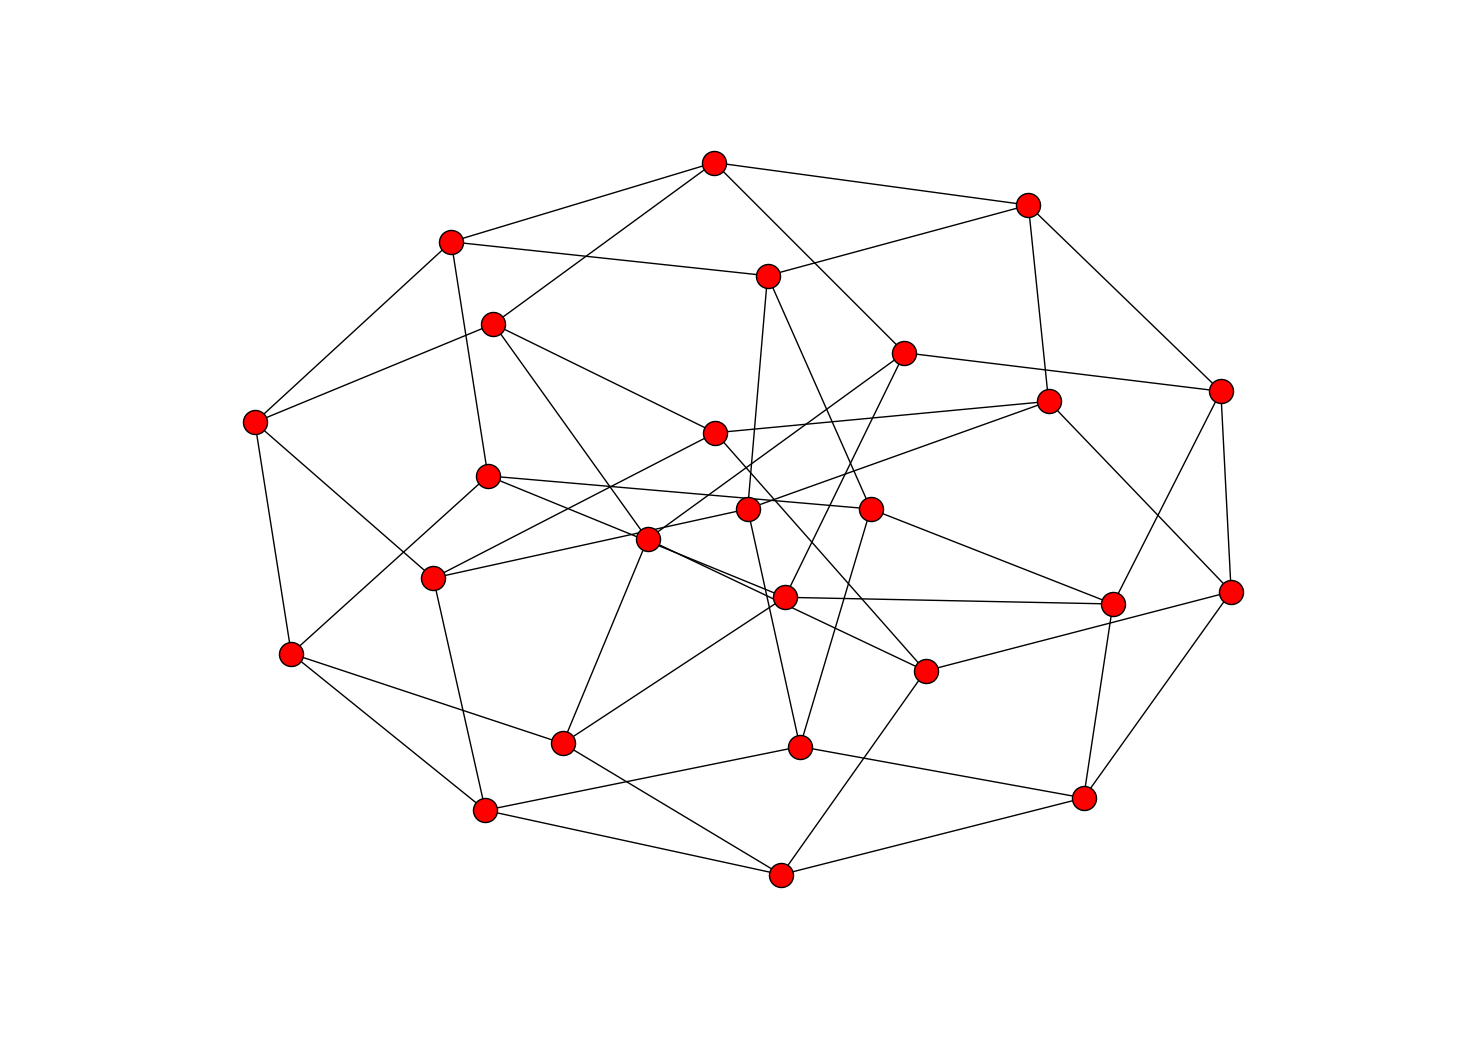

In [21]:
RG = nx.grid_graph(dim=[5,5], periodic=True)
pos = dict(zip(RG,RG))
nx.draw_graphviz(RG) 

In [22]:
x,y,env_id = 5,5,2
torus = load_torus(x, y, env_id)
special_nodes = get_torus_start_and_target(x, y)
original_nodes = [n for n in torus.nodes() if n not in special_nodes]
    
grid, twin_row, twin_column = create_grid_with_twin_nodes(torus, x,y)
old_edges  = set(torus.edges())
for i, e in enumerate([e for e in grid.edges() if e not in old_edges]):
    print i, e


0 (0, (4, 'twin_column'))
1 (0, (20, 'twin_row'))
2 (1, (21, 'twin_row'))
3 (2, (22, 'twin_row'))
4 (3, (23, 'twin_row'))
5 (4, (24, 'twin_row'))
6 (5, (9, 'twin_column'))
7 (10, (14, 'twin_column'))
8 (15, (19, 'twin_column'))
9 (20, (24, 'twin_column'))


## Переведем сохраненные графы в другой формат

Следующая ячейка сохраняет данные о сгенерированных средах в формат GEXF. Если такие файлы уже имеются то запускать её не нужно. 

In [ ]:
import os

def ensure_dir(filename):
    """Check if directories in filename exists if not creates corresponding directories!"""
    d = path.dirname(filename)
    if not path.exists(d):
        os.makedirs(d)

gexf_file_template = path.join(root_dir, 'env_data/GEXF_format/{topology}/{size}/{env_id}.gexf')

topology_2_load_func = {
    'barabasi_albert': load_barabasi_albert,
    'watts_strogatz': load_watts_strogatz,
    'erdos_renyi': load_erdos_renyi
}


for name, load in topology_2_load_func.items():
    print 'saving ', name, 'graphs'
    for size in ['small', 'medium', 'big']:
        for i in xrange(1,11):
            print '{0}({1})'.format(size, i)
            env_graph = load(i, size)
            filename = gexf_file_template.format(topology=name, size=size, env_id=i)
            ensure_dir(filename)
            nx.write_gexf(env_graph, filename)

In [25]:

def test_GEXF():
    gexf_file_template = path.join(root_dir, 'env_data/GEXF_format/{topology}/{size}/{env_id}.gexf')
    p = gexf_file_template.format(topology='barabasi_albert', size='small', env_id=2)
    G1 = nx.read_gexf(p, node_type=int)
    G2 = load_barabasi_albert(2)
    print 'nodes are equal:', G1.nodes() == G2.nodes()
    print 'edges are equal:', G1.edges() == G2.edges()
    for e1,e2 in zip(G1.edges(), G2.edges()):
        v1, u1 = e1
        v2, u2 = e2
        e1_data = G1[v1][u1]     
        e2_data = G2[v2][u2]
        assert e1_data['is_available'] == e2_data['is_available'], '({0},{1}).is_available attr differs for two graphs'
        assert e1_data['prob'] == e2_data['prob'], '({0},{1}).prob attr differs for two graphs'
    
test_GEXF()

nodes are equal: True
edges are equal: True
